In [11]:
import pandas as pd
import numpy as np

from functools import reduce

from sqlalchemy import create_engine

from datetime import date

In [ ]:
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
users = pd.read_json('data/profile.json', orient='records', lines=True)
interactions = pd.read_json('data/transcript.json', orient='records', lines=True)

offer_col_mapping = {
    'id': 'offer_id', 
    'channels': 'offer_notification_channel', 
    'offer_type': 'offer_type', 
    'difficulty': 'offer_spend_minimum', 
    'reward': 'offer_reward', 
    'duration': 'offer_duration'
}

users_col_mapping = {
    'id': 'user_id', 
    'gender': 'user_gender', 
    'age': 'user_age', 
    'became_member_on': 'user_member_since', 
    'income': 'user_income'
}

interactions_col_mapping = {
    'person': 'user_id', 
    'event': 'intxn_event_type', 
    'value': 'intxn_value', 
    'time': 'intxn_time'
}

# Reordering and renaming columns for offers
offers = offers[ list( offer_col_mapping.keys() ) ]
offers = offers.rename( columns=offer_col_mapping )

# Exploding the offers table so that we have one row per channel per offer
offers = offers.explode('offer_notification_channel')

# Reordering and renaming columns for users
users = users[ list( users_col_mapping.keys() ) ]
users = users.rename( columns=users_col_mapping )

# Users with age 118 are users that do not have an age in their profile
users['user_age'] = users['user_age'].apply( lambda x: np.nan if x == 118 else x )
users['user_member_since'] = pd.to_datetime(users['user_member_since'], format='%Y%m%d', errors='coerce')
users['user_tenure'] = users['user_member_since'].apply( lambda x: ( pd.Timestamp(2019, 1, 1) - x).days if pd.notnull(x) else np.nan )

# Reordering and renaming columns for interactions
interactions = interactions[ list( interactions_col_mapping.keys() ) ]
interactions = interactions.rename( columns=interactions_col_mapping )

display(interactions)

# Expanding the interaction value column into separate columns
intxn_value_expanded = pd.json_normalize( interactions['intxn_value'] )
display( intxn_value_expanded )

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.combine_first.html
intxn_value_expanded['offer_id'] = intxn_value_expanded['offer_id'].combine_first( intxn_value_expanded['offer_id'] )
intxn_value_expanded = intxn_value_expanded.drop(columns=['offer_id'])
display( intxn_value_expanded )

intxn_value_expanded = intxn_value_expanded.rename( columns={ col: f'intxn_{col}' for col in intxn_value_expanded.columns.tolist() } )

display(intxn_value_expanded)

# Adding the expanded interaction value columns back into the interactions dataframe
interactions = pd.concat([interactions, intxn_value_expanded], axis=1)

,user_id,intxn_event_type,intxn_value,intxn_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


,offer id,amount,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...
306529,NaN,1.59,NaN
306530,NaN,9.53,NaN
306531,NaN,3.61,NaN
306532,NaN,3.53,NaN


,intxn_offer id,intxn_amount,intxn_reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...
306529,NaN,1.59,NaN
306530,NaN,9.53,NaN
306531,NaN,3.61,NaN
306532,NaN,3.53,NaN


In [3]:
users

,user_id,user_gender,user_age,user_member_since,user_income,user_tenure
0,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12,NaN,688
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,535
2,38fe809add3b4fcf9315a9694bb96ff5,None,NaN,2018-07-12,NaN,173
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,602
4,a03223e636434f42ac4c3df47e8bac43,None,NaN,2017-08-04,NaN,515
...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,2018-06-04,54000.0,211
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,2018-07-13,72000.0,172
16997,01d26f638c274aa0b965d24cefe3183f,M,49.0,2017-01-26,73000.0,705
16998,9dc1421481194dcd9400aec7c9ae6366,F,83.0,2016-03-07,50000.0,1030


In [4]:
# offers.groupby( ['offer_notification_channel', 'offer_type'] ).count()['offer_id'].reset_index().sort_values( 'offer_notification_channel' ).rename( columns={ 'offer_id': 'offer_count' } )

In [5]:
user_age_groupings = {
    '0-18': (0, 18),
    '19-25': (19, 25),
    '26-35': (26, 35),
    '36-45': (36, 45),
    '46-55': (46, 55),
    '56-65': (56, 65),
    '66+': (66, np.inf)
}

users['user_age_group'] = pd.cut( users['user_age'], bins=[0, 18, 25, 35, 45, 55, 65, np.inf], labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+'], right=False )

users

,user_id,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group
0,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12,NaN,688,NaN
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,535,56-65
2,38fe809add3b4fcf9315a9694bb96ff5,None,NaN,2018-07-12,NaN,173,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,602,66+
4,a03223e636434f42ac4c3df47e8bac43,None,NaN,2017-08-04,NaN,515,NaN
...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,2018-06-04,54000.0,211,46-55
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,2018-07-13,72000.0,172,56-65
16997,01d26f638c274aa0b965d24cefe3183f,M,49.0,2017-01-26,73000.0,705,46-55
16998,9dc1421481194dcd9400aec7c9ae6366,F,83.0,2016-03-07,50000.0,1030,66+


<Axes: title={'center': 'Counts per User Age Group'}, xlabel='Age Group', ylabel='Count'>

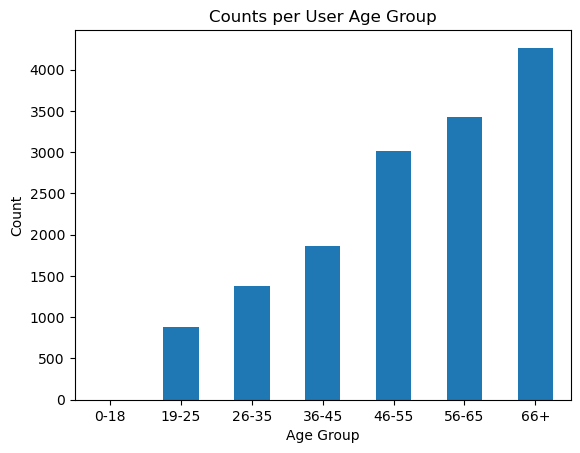

In [6]:
users['user_age_group'].value_counts().sort_index().plot(kind='bar', title='Counts per User Age Group', xlabel='Age Group', ylabel='Count', rot=0)

In [7]:
users.groupby( ['user_gender'], dropna=False ).count()

,user_id,user_age,user_member_since,user_income,user_tenure,user_age_group
user_gender,,,,,,
F,6129,6129,6129,6129,6129,6129
M,8484,8484,8484,8484,8484,8484
O,212,212,212,212,212,212
NaN,2175,0,2175,0,2175,0


In [8]:
interactions

,user_id,intxn_event_type,intxn_value,intxn_time,intxn_offer id,intxn_amount,intxn_offer_id,intxn_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN,3.53,NaN,NaN


In [9]:
interactions.groupby(['intxn_event_type', 'intxn_offer_id'], dropna=False).count()['user_id'].reset_index().rename( columns={ 'user_id': 'intxn_count' } ).sort_values('intxn_count')

,intxn_event_type,intxn_offer_id,intxn_count
3,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,3331
0,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,3420
5,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,3688
2,offer completed,2906b810c7d4411798c6938adc9daaa5,4017
6,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,4296
4,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,4354
1,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,5156
7,offer completed,fafdcd668e3743c1bb461111dcafc2a4,5317
9,offer viewed,NaN,57725
8,offer received,NaN,76277


In [10]:
interactions[ interactions['intxn_event_type'] == 'offer received' ]

,user_id,intxn_event_type,intxn_value,intxn_time,intxn_offer id,intxn_amount,intxn_offer_id,intxn_reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN


In [13]:
interactions.groupby('intxn_event_type', dropna=False).count()['user_id'].reset_index().rename( columns={ 'user_id': 'intxn_count' } ).sort_values('intxn_count')

,intxn_event_type,intxn_count
0,offer completed,33579
2,offer viewed,57725
1,offer received,76277
3,transaction,138953


In [16]:
offers_received = interactions[ interactions['intxn_event_type'] == 'offer received' ]
offers_completed = interactions[ interactions['intxn_event_type'] == 'offer completed' ]
offers_viewed = interactions[ interactions['intxn_event_type'] == 'offer viewed' ]
transactions = interactions[ interactions['intxn_event_type'] == 'transaction' ]

offers_received = offers_received.drop( columns=['intxn_amount', 'intxn_reward'] )

In [17]:
offers_received

,user_id,intxn_event_type,intxn_value,intxn_time,intxn_offer id,intxn_offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,ae264e3637204a6fb9bb56bc8210ddfd,NaN
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,2906b810c7d4411798c6938adc9daaa5,NaN
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,ae264e3637204a6fb9bb56bc8210ddfd,NaN


In [11]:
# conn = create_engine('sqlite:///data/raw_starbucks.db')

# portfolio.to_sql('portfolio', conn, if_exists='replace', index=False)
# profile.to_sql('profile', conn, if_exists='replace', index=False)
# transcript.to_sql('transcript', conn, if_exists='replace', index=False)

# conn.dispose()